# Test dim of LHC dataset

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
import torch
from torch import nn

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.datasets import WBFLoader, WBF40DLoader
from experiments.training import Nu
import plot_settings as ps


In [2]:
ps.setup()

## Autoencoder

In [45]:
def test_latent_dim(dim, epochs=50, lr=1.e-2, batchsize=200):
    print(f"Starting AE training with latent dim {dim}")
    
    autoencoder = nn.Sequential(
        nn.Linear(40, 25),
        nn.ReLU(),
        nn.Linear(25, dim),
        nn.ReLU(),
        nn.Linear(dim, 25),
        nn.ReLU(),
        nn.Linear(25, 40)
    )
    
    dataset = WBF40DLoader().load_dataset(train=True, dataset_dir="../data/samples/lhc40d")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.
        for data in dataloader:
            x, _ = data
            x_reco = autoencoder(x)
            loss = criterion(x_reco, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch)
            total_loss += loss.item()

        print('Epoch {}: reco error = {:.4f}'.format(epoch+1, total_loss / len(dataloader)))
        
    autoencoder.eval()
    dataset = WBF40DLoader().load_dataset(train=True, dataset_dir="../data/samples/lhc40d")
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)
    test_loss = 0.
    for data in dataloader:
        x, _ = data
        x_reco = autoencoder(x)
        loss = criterion(x_reco, x)
        test_loss += loss.item()
        
    print('Test reco error = {:.4f}'.format(test_loss / len(dataloader)))
    print('')
    
    return test_loss / len(dataloader)
    

In [46]:
dims = [20, 18, 16, 14, 12, 10, 8, 6, 4, 2]

mses = [test_latent_dim(dim) for dim in dims]

Starting AE training with latent dim 20
Epoch 1: reco error = 0.0405
Epoch 2: reco error = 0.0229
Epoch 3: reco error = 0.0197
Epoch 4: reco error = 0.0194
Epoch 5: reco error = 0.0192
Epoch 6: reco error = 0.0190
Epoch 7: reco error = 0.0190
Epoch 8: reco error = 0.0189
Epoch 9: reco error = 0.0186
Epoch 10: reco error = 0.0186
Epoch 11: reco error = 0.0183
Epoch 12: reco error = 0.0184
Epoch 13: reco error = 0.0182
Epoch 14: reco error = 0.0181
Epoch 15: reco error = 0.0181
Epoch 16: reco error = 0.0180
Epoch 17: reco error = 0.0180
Epoch 18: reco error = 0.0179
Epoch 19: reco error = 0.0178
Epoch 20: reco error = 0.0178
Epoch 21: reco error = 0.0176
Epoch 22: reco error = 0.0176
Epoch 23: reco error = 0.0174
Epoch 24: reco error = 0.0174
Epoch 25: reco error = 0.0173
Epoch 26: reco error = 0.0173
Epoch 27: reco error = 0.0172
Epoch 28: reco error = 0.0171
Epoch 29: reco error = 0.0171
Epoch 30: reco error = 0.0170
Epoch 31: reco error = 0.0169
Epoch 32: reco error = 0.0168
Epoch 33:

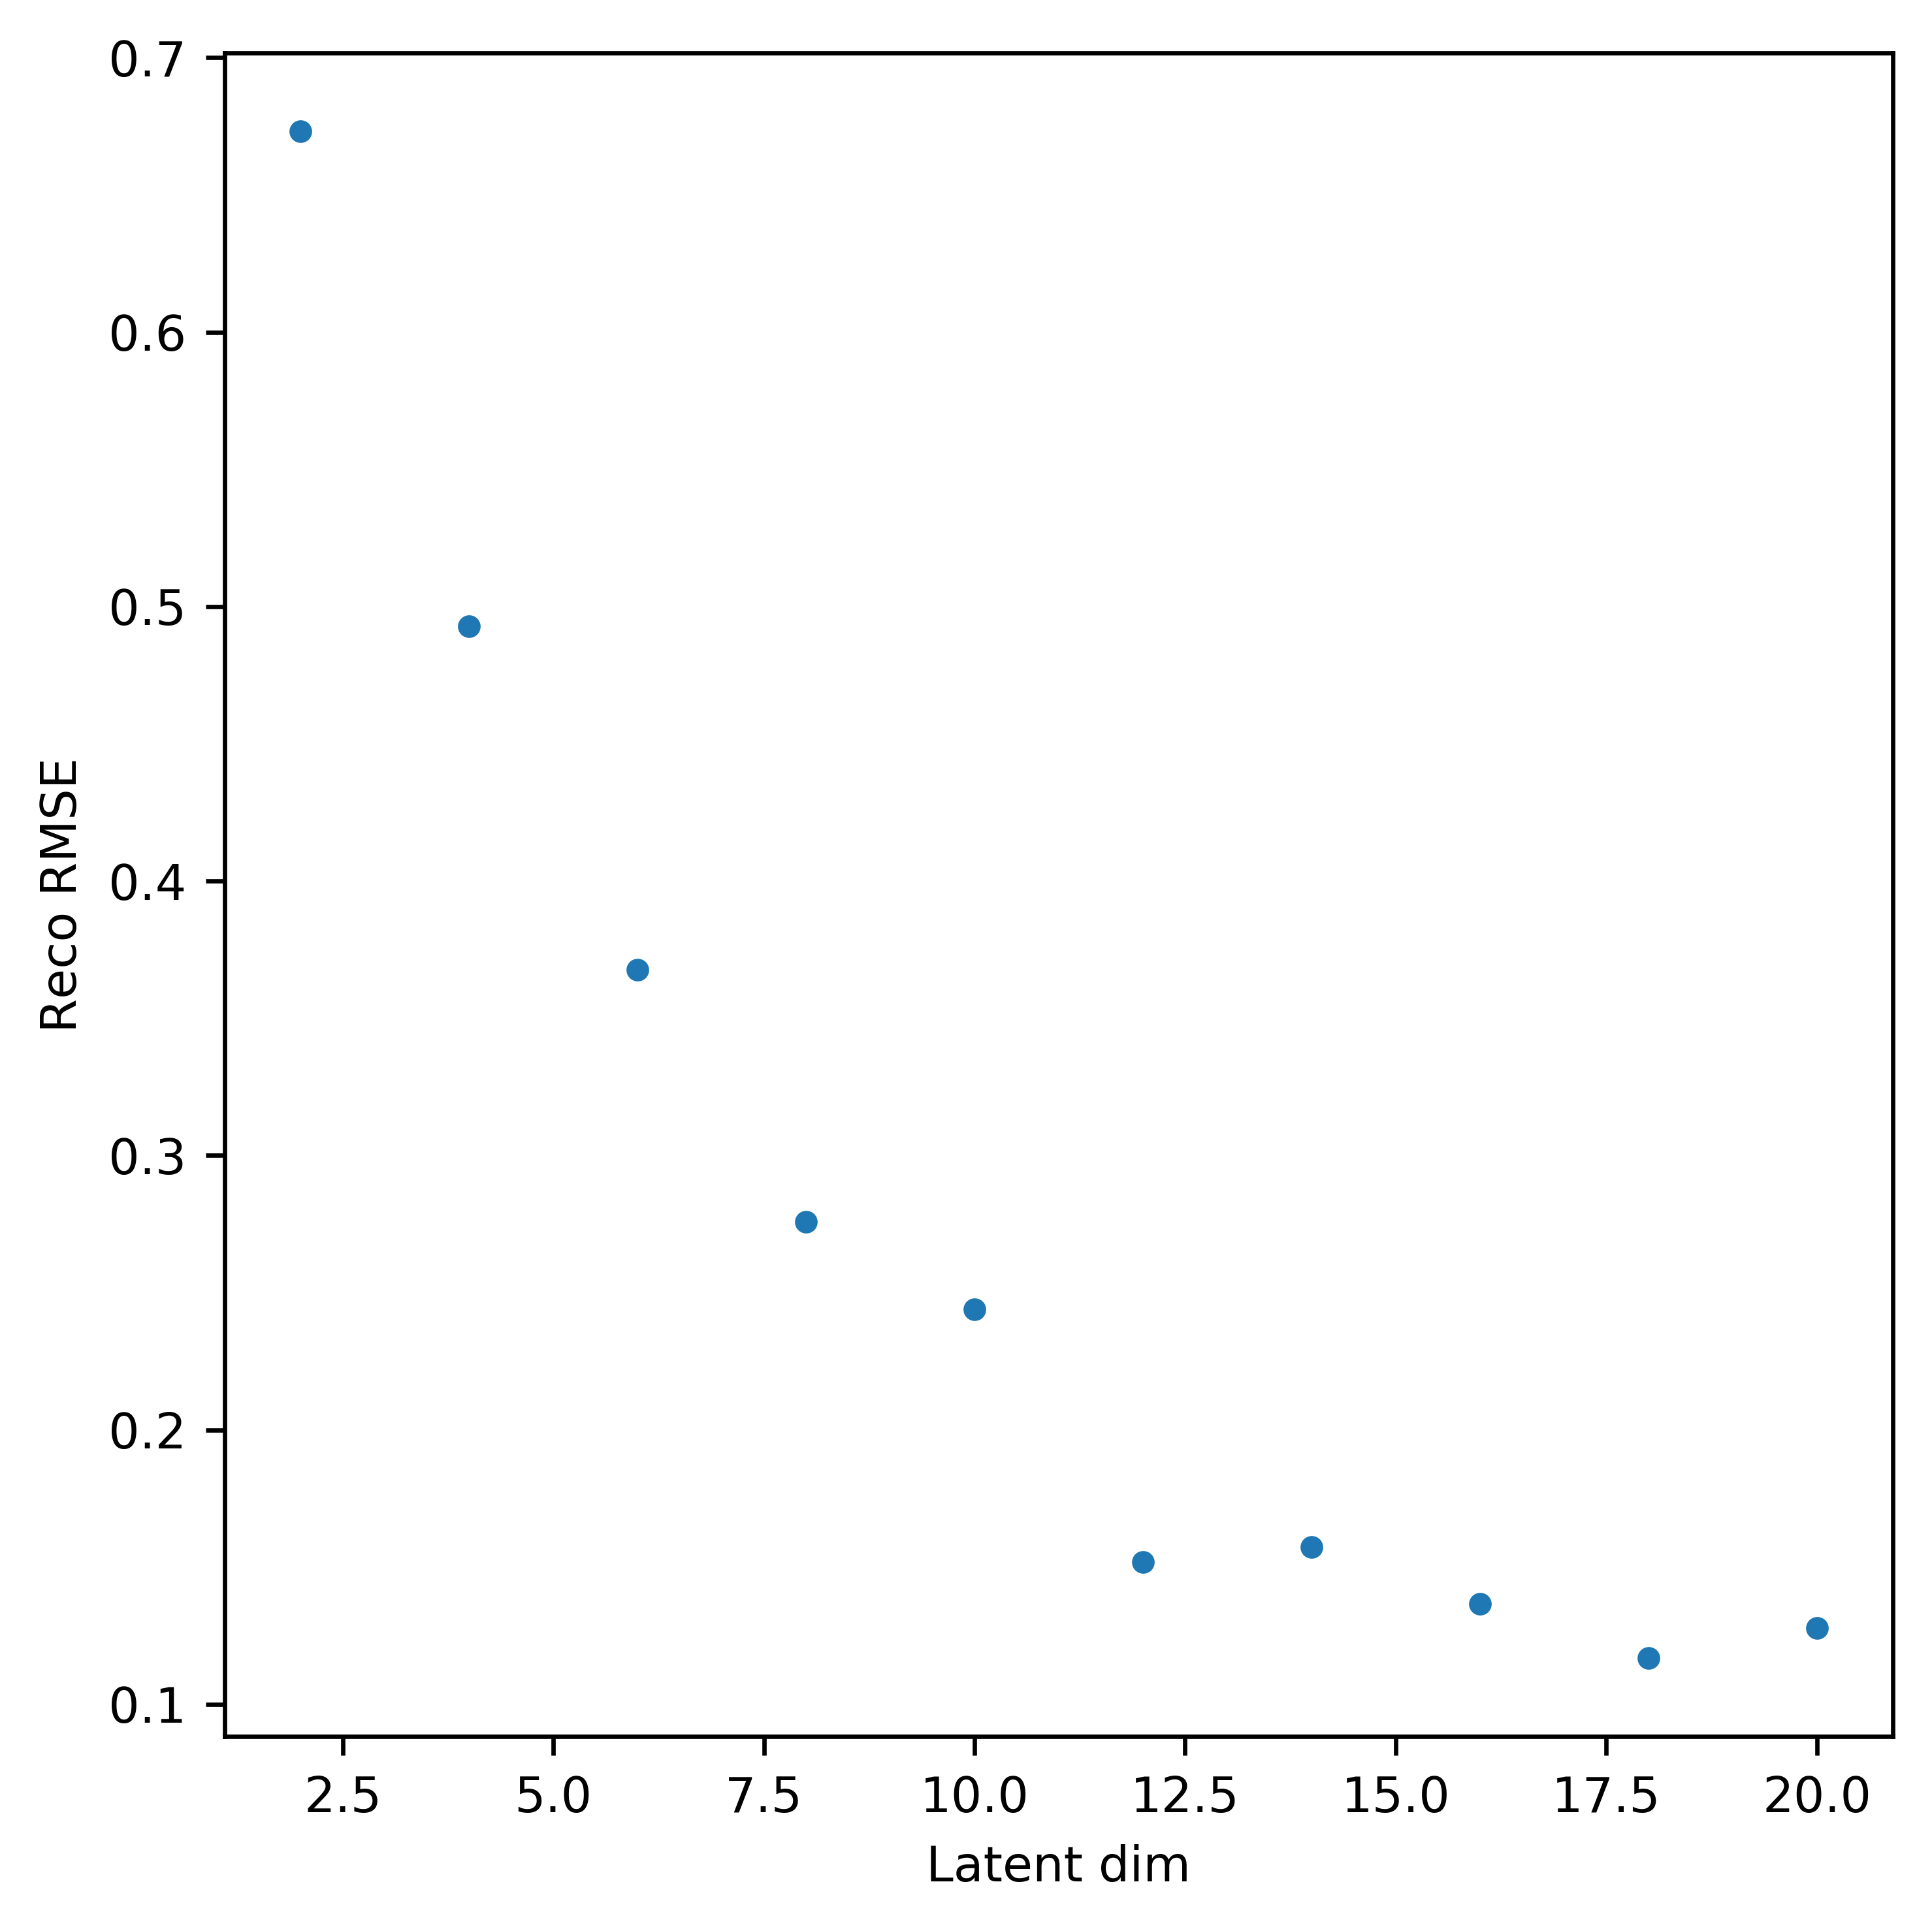

In [48]:
fig = plt.figure(figsize=(5,5))

plt.scatter(dims, np.array(mses)**0.5, s=10.)

plt.xlabel("Latent dim")
plt.ylabel("Reco RMSE")

plt.tight_layout()
plt.show()
